In [10]:
import pandas as pd
import numpy as np
import os
import email
import email.policy
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
PATH = 'C:/Users/dtmt1/Desktop/Zummit/006-Spam_detection/'
ham_filenames = [name for name in os.listdir(PATH+'ham')]
spam_filenames = [name for name in os.listdir(PATH+'spam')]
random.shuffle(ham_filenames)  #shuffle first
random.shuffle(spam_filenames)

In [13]:
def load_email(is_spam,filename,path):
    if is_spam :
        path = path + 'spam/' + filename
    else :
        path = path + 'ham/' + filename
    with open(path,'rb') as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

ham_emails = [load_email(False,name,PATH) for name in ham_filenames]
spam_emails = [load_email(True,name,PATH) for name in spam_filenames]

#remove not text type emails
ham_emails = [email for email in ham_emails if type(email.get_payload()) is str or len(email.get_payload())>1] 
spam_emails = [email for email in spam_emails if type(email.get_payload()) is str or len(email.get_payload())>1]

print('Number of spam emails:',len(spam_emails))
print('Number of ham emails:',len(ham_emails))

Number of spam emails: 458
Number of ham emails: 2548


In [21]:
test_email = spam_emails[0]
print('Example email content:\n\n',test_email.get_payload()[:250])  #limit the size to 400 chars
print('\n')
# print(test_email)

Example email content:

 Protect your financial well-being.
Purchase an Extended Auto Warranty for your Car today. CLICK HERE for a FREE no obligation quote.
http://www.newnamedns.com/warranty/
  
Car troubles always seem to happen at the worst possible time. Protect yoursel




In [22]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
ps = PorterStemmer()

In [29]:
import re
import string
def process_email(content) :
    
    if not isinstance(content,str) :       
        return {},''
    content = re.sub(r'<[^<>]+>', ' ',content)  ##strip all HTML
    content = str.lower(content) ##lower case
    
    #handle URLS with http:// or https://
    content = re.sub(r'(http|https)://[^\s]*','httpaddr ',content) 
    
    #handle email addresses
    #look for strings with @ in the middle
    content = re.sub(r'[^\s]+@[^\s]+','emailaddr',content)
    
    content = re.sub(r'[0-9]+', 'number ',content) #handle numbers
    content = re.sub(r'[$]+','dollar ',content) #handle $ sign 
    content = re.sub(r'[\n]+',' ',content) #remove \n
    #remove punctuaion
    content = re.sub(r'[{0}]'.format(string.punctuation),' ',content) 
    
    res = {}
    words = word_tokenize(content)
    content = ' '.join([ps.stem(word) for word in words])
    for word in words :
        word = ps.stem(word)
        if len(word) > 11 :
            continue
        if len(word) <=1 :
            continue
        if not res.get(word):
            res[word] = 0
        res[word] += 1
    
    return res,content

In [30]:
(res,content) = process_email(test_email.get_payload())
print('Email content becomes(only list 500 chars):\n\n',process_email(test_email.get_payload())[1][:500]) 
print('\n')
print(res)

Email content becomes(only list 500 chars):

 protect your financi well be purchas an extend auto warranti for your car today click here for a free no oblig quot httpaddr car troubl alway seem to happen at the worst possibl time protect yourself and your famili with a qualiti extend warranti for your car truck or suv so that a larg expens can not hit you all at onc we cover most vehicl with less than number number mile buy direct our price are number number less we offer fair price and prompt toll free claim servic get an extend warranti on


{'protect': 2, 'your': 6, 'financi': 1, 'well': 1, 'be': 1, 'purchas': 1, 'an': 2, 'extend': 4, 'auto': 1, 'warranti': 4, 'for': 5, 'car': 4, 'today': 2, 'click': 2, 'here': 2, 'free': 3, 'no': 2, 'oblig': 2, 'quot': 2, 'httpaddr': 3, 'troubl': 1, 'alway': 1, 'seem': 1, 'to': 3, 'happen': 1, 'at': 2, 'the': 2, 'worst': 1, 'possibl': 1, 'time': 1, 'yourself': 1, 'and': 2, 'famili': 1, 'with': 2, 'qualiti': 1, 'truck': 1, 'or': 1, 'suv': 1, 'so': 1,

In [33]:
def build_vocab(emails) :
    '''
    build_vocab will build a vocabulary with words 
    appearing in the email content
    @emails : list of email
    @return : 
    '''
    assert isinstance(emails,list)
    dic = {}
    index = 0
    
    while index < len(emails) :
        email = emails[index]
        judge = email.get_payload()
        if type(judge) is not str:
            dict_email = {}
            for e in judge :
                dic_toadd = process_email(e.get_payload())
                for word in dic_toadd[0] :
                    if not dic_email.get(word):
                        dic_email[word] = 0
                    dic_email[word] += 1
        else :
            dic_email = process_email(judge)[0]
        for word in dic_email.keys() :
            if not dic.get(word) :
                dic[word] = 0
            dic[word] += dic_email[word]
        index+=1
    
    return dic
# print(test_email['Subject'])
vocab = build_vocab(spam_emails)
print('number of total words in spam emails:', len(vocab.keys()))
vocab = [word for word in vocab.keys() if vocab[word]>11]
print('number of words that with frequency than 11:', vocab)
n = len(vocab)

number of total words in spam emails: 44304
number of words that with frequency than 11: ['protect', 'your', 'financi', 'well', 'be', 'purchas', 'an', 'extend', 'auto', 'warranti', 'for', 'car', 'today', 'click', 'here', 'free', 'no', 'oblig', 'quot', 'httpaddr', 'troubl', 'alway', 'seem', 'to', 'happen', 'at', 'the', 'worst', 'possibl', 'time', 'yourself', 'and', 'famili', 'with', 'qualiti', 'or', 'so', 'that', 'larg', 'expens', 'can', 'not', 'hit', 'you', 'all', 'onc', 'we', 'cover', 'most', 'less', 'than', 'number', 'mile', 'buy', 'direct', 'our', 'price', 'are', 'offer', 'fair', 'prompt', 'toll', 'claim', 'servic', 'get', 'on', 'plan', 'also', 'includ', 'hour', 'assist', 'benefit', 'easili', 'remov', 'address', 'from', 'list', 'go', 'pleas', 'allow', 'link', 'decor', 'none', 'activ', 'da', 'visit', 'over', 'ff', 'text', 'nbsp', 'newslett', 'discov', 'immedi', 'releas', 'stock', 'cbyi', 'watch', 'strong', 'recommend', 'sever', 'ry', 'pick', 'ha', 'file', 'trade', 'share', 'increas',

In [26]:
df_vo = pd.DataFrame(vocab)
df_vo = df_vo.rename(columns={0:'words'})
df_vo.to_csv('vocabulary.csv',index=False)

In [34]:
import random
class emailToFeature:
    '''
    This is a class for building feature vectors
    '''
    def __init__(self,filename) :
        vocab = pd.read_csv(filename)
        vocab = list(vocab['words'])
        index = 0
        vocabulary = {}
        while index < len(vocab) :
            vocabulary[vocab[index]] = index
            index+=1
        self.d = len(vocab)
        self.vocab = vocabulary   
    
    def fea_vector(self,email) :
        '''
        return a numpy array(1Xn) representing the
        feature vector
        @email: input email can be both a string and email object
        '''
        if type(email) is str:
            judge = email
        else :
            judge = email.get_payload()
        if not type(judge) is str:
            dic_email = {}
            for e in judge :
                dic_toadd = process_email(e.get_payload())
                for word in dic_toadd[0] :
                    if not dic_email.get(word):
                        dic_email[word] = 0
                    dic_email[word] += 1
        else :
            dic_email = process_email(judge)[0]
            
        res = np.zeros((1,self.d))
        for word in dic_email.keys() :
            if not self.vocab.get(word):
                continue
            index = self.vocab[word]
            res[0,index] = 1
        return res
    
    def build_vectors(self,is_spam,emails) :
        '''
        build feature vectors
        
        @emails : list of ham or spam emails
        @return : numpy array representing feature vectors
        '''
        N = len(emails)  # N*d array
        fea_vectors = np.zeros((N,self.d+1))
        for i in range(N) :
            a = self.fea_vector(emails[i])
            fea_vectors[i,:-1] = a
        if is_spam :
            fea_vectors[:,self.d] = 1
        else :
            fea_vectors[:,self.d] = 0
        return fea_vectors

In [35]:

#construct feature vectors and export them to csv files
emailTof = emailToFeature('vocabulary.csv') #class object
spam_vectors = emailTof.build_vectors(True,spam_emails)
ham_vectors = emailTof.build_vectors(False,ham_emails)

index = list(range(n+1))
spam_df = pd.DataFrame(spam_vectors,columns=index)
spam_df.to_csv('spam_vectors.csv',index = False)
ham_df = pd.DataFrame(ham_vectors,columns=index)
ham_df.to_csv('ham_vectors.csv',index=False)

print('size of spam feature vectors is:',spam_vectors.shape)
print('size of ham feature vectors is:',ham_vectors.shape)

size of spam feature vectors is: (458, 1741)
size of ham feature vectors is: (2548, 1741)


In [36]:
ham_training = ham_vectors[:1530]
ham_validation,ham_test = ham_vectors[1530:2039],ham_vectors[2039:]

spam_training = spam_vectors[:274]
spam_validation,spam_test = spam_vectors[274:365],spam_vectors[365:]

training = np.concatenate((ham_training,spam_training))
np.random.shuffle(training)
pd.DataFrame(training,columns=index).to_csv('training.csv',index=False)

cval = np.concatenate((ham_validation,spam_validation))
test = np.concatenate((ham_test,spam_test))
pd.DataFrame(cval,columns=index).to_csv('cross-validation.csv',index=False)
pd.DataFrame(test,columns=index).to_csv('test.csv',index=False)

In [37]:
#Get word frequency distribution in both spam and non-spam email
#60% training data and 20% test data, the same as above
#Only use the word whose frequency difference between spam and non-spam email is greater than 20
vocab_spam = build_vocab(spam_emails[0:274])
vocab_ham = build_vocab(ham_emails[0:1530])
voc = [word for word in vocab_spam.keys() if vocab_ham.get(word) and abs(vocab_ham[word] - vocab_spam[word]) > 20] 
vocab_ham = {word:vocab_ham[word] for word in voc}
vocab_spam = {word:vocab_spam[word] for word in voc}
sum_ham,sum_spam = sum(list(vocab_ham.values())),sum(list(vocab_spam.values()))
vocab_ham = {word:vocab_ham[word]/sum_ham for word in voc}   # key is word and value is probability in ham eamils
vocab_spam = {word:vocab_spam[word]/sum_spam for word in voc} # key is word and value is probability in spam eamils

In [38]:
spam_test,ham_test = spam_emails[365:],ham_emails[2039:]

In [39]:
word_spam = list(vocab_spam.keys())
word_spam.sort(key=lambda x:vocab_spam[x],reverse=True)
word_spam = word_spam[:100] #choose 100 words
y_spam, y_ham= [vocab_spam[word] for word in word_spam],[vocab_ham[word] for word in word_spam]

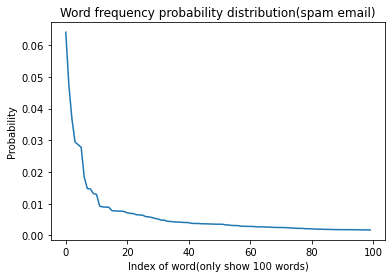

In [40]:
plt.plot(list(range(100)),y_spam)
plt.ylabel('Probability')
plt.xlabel('Index of word(only show 100 words)')
plt.title('Word frequency probability distribution(spam email)')
plt.show()

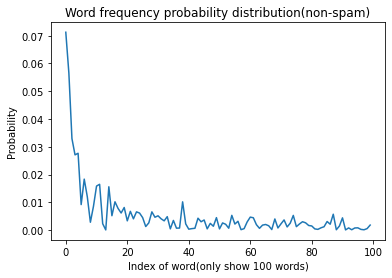

In [41]:
plt.plot(list(range(100)),y_ham)
plt.ylabel('Probability')
plt.xlabel('Index of word(only show 100 words)')
plt.title('Word frequency probability distribution(non-spam)')
plt.show()

In [42]:
def process_single(email):
    '''
    Return a str which represents processed email content
    '''
    judge = email.get_payload()
    dic = {}
    if type(judge) is not str:
        dic_email = {}
        for e in judge :
            dic_toadd = process_email(e.get_payload())
            for word in dic_toadd[0] :
                if not dic_email.get(word):
                    dic_email[word] = 0
                dic_email[word] += 1
    else :
        dic_email = process_email(judge)[0]
    for word in dic_email.keys() :
        if not dic.get(word) :
            dic[word] = 0
        dic[word] += dic_email[word]
    return dic

In [43]:
def com_precision(y,y_p):
    '''
    y is true classification
    y_p is predicted classification
    '''
    length = len(y)
    num_pre1 = np.sum(y_p)
    num_correct = 0
    for i in range(length) :
        if y_p[i] != 1:
            continue
        if y[i] == 1:
            num_correct += 1
    return num_correct / num_pre1

def com_recall(y,y_p) :
    '''
    y is true classification
    y_p is predicted classification
    '''
    actual1 = np.sum(y)
    length = len(y)
    num_correct = 0
    for i in range(length) :
        if y[i]!=1 :
            continue 
        if y_p[i] == 1:
            num_correct += 1
    return num_correct / actual1

def com_f1Score(precision,recall):
    '''
    Compute F1-score
    ''' 
    return 2*precision*recall/(precision+recall)

def com_error(y,y_p):
    '''
    compute error
    '''
    vali = np.ones(len(y))
    vali = vali[y == y_p]
    return 1-np.sum(vali) / len(y_p)

In [44]:
#Predict
indexs_spam = np.array([0]*(len(spam_test)+len(ham_test))) #this will be the predicted array 
judge_array = np.array([1]*len(spam_test)+[0]*len(ham_test)) # this is the true value array
emails_t = spam_test + ham_test
for i in range(len(spam_test)+len(ham_test)):
    email = emails_t[i]
    con = process_single(email)
    con = {word:con[word] for word in con if vocab_spam.get(word)}
    df = pd.DataFrame.from_dict(con,orient='index',columns=['frequency'])
    prob_spam = np.array([vocab_spam[word] for word in df.index if vocab_spam.get(word)])
    prob_spam = np.log(prob_spam)
    df['prob_spam'] = prob_spam
    prob_ham = np.array([vocab_ham[word] for word in df.index if vocab_spam.get(word)])
    prob_ham = np.log(prob_ham)
    df['prob_ham'] = prob_ham
    if ((df['prob_spam'] * df['frequency']).sum()+np.log(0.1524) >= (df['prob_ham'] * df['frequency']).sum()+np.log(1-0.1524)) :
        indexs_spam[i] = 1

In [45]:
error_bayes = com_error(judge_array,indexs_spam)
precision_bayes = com_precision(judge_array,indexs_spam)
recall_bayes = com_recall(judge_array,indexs_spam)
print('precision for Naive Bayes is:',precision_bayes)
print('recall for Naive Bayes is:',recall_bayes)
print('error for Naive Bayes is:',error_bayes)
print('percentage of accuracy is:','{0:.4}'.format((1-error_bayes)*100)+'%')

precision for Naive Bayes is: 0.9662921348314607
recall for Naive Bayes is: 0.9247311827956989
error for Naive Bayes is: 0.01661129568106312
percentage of accuracy is: 98.34%
